In [10]:
import keras
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import librosa.feature
import requests

In [2]:
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

audio = requests.get(url).content
open(fn,'wb').write(audio)

1418242

In [3]:
y, sr = librosa.load(fn)

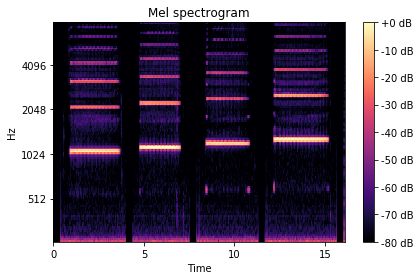

In [4]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.logamplitude(S,ref_power=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [5]:
data_dir = 'instrument_dataset/'
Xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
Xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

#There are 66247 training and 14904 test samples
#There are 120 features per sample and 10 classes

In [6]:
Xtr_scale = (Xtr - np.mean(Xtr)) / np.std(Xtr)
Xts_scale = (Xts - np.mean(Xts)) / np.std(Xts)

In [11]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation
import keras.backend as K
K.clear_session()

In [25]:
nin = Xtr_scale.shape[1]  # dimension of input data
nh = 256     # number of hidden units
nout = int(np.max(ytr)+1)    # number of outputs = 10 since there are 10 classes
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(nout, activation='sigmoid', name='output'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 256)               30976     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
_________________________________________________________________


In [34]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_acc = []
 
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        self.val_acc.append(logs.get('val_acc'))

# Create an instance of the history callback
history_cb = LossHistory()

In [27]:
from keras import optimizers

opt = optimizers.Adam(lr=0.001) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])


In [39]:
model.fit(Xtr_scale, ytr, epochs=10, batch_size=100, validation_data=(Xts_scale,yts), callbacks=[history_cb])

Train on 66247 samples, validate on 14904 samples
Epoch 1/10
66247/66247 [==============================] - 1s - loss: 0.0447 - acc: 0.9883 - val_loss: 0.3225 - val_acc: 0.9156
Epoch 2/10
66247/66247 [==============================] - 1s - loss: 0.0445 - acc: 0.9881 - val_loss: 0.3346 - val_acc: 0.9165
Epoch 3/10
66247/66247 [==============================] - 1s - loss: 0.0431 - acc: 0.9886 - val_loss: 0.3041 - val_acc: 0.9229
Epoch 4/10
66247/66247 [==============================] - 1s - loss: 0.0427 - acc: 0.9890 - val_loss: 0.2970 - val_acc: 0.9284
Epoch 5/10
66247/66247 [==============================] - 1s - loss: 0.0416 - acc: 0.9895 - val_loss: 0.3298 - val_acc: 0.9179
Epoch 6/10
66247/66247 [==============================] - 1s - loss: 0.0419 - acc: 0.9889 - val_loss: 0.3034 - val_acc: 0.9240
Epoch 7/10
66247/66247 [==============================] - 1s - loss: 0.0406 - acc: 0.9892 - val_loss: 0.2907 - val_acc: 0.9273
Epoch 8/10
66247/66247 [==============================] - 1s 

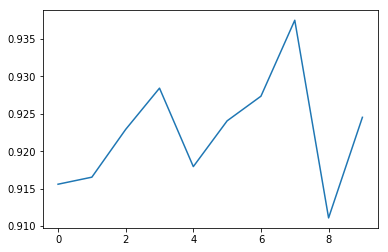

In [40]:
plt.plot(history_cb.val_acc)

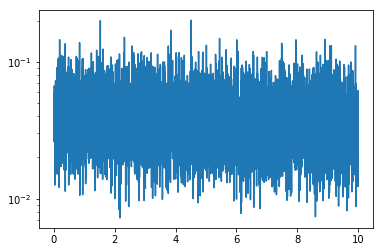

In [53]:
epoch = []
for i in range(len(history_cb.loss)):
    epoch.append(i*100/66247)
plt.semilogy(epoch,history_cb.loss)

In [60]:
rates = [0.01,0.001,0.0001]
batch_size = 100
loss_hist = []
val_acc_hist = []

for rate in rates:
    K.clear_session()
    nin = Xtr_scale.shape[1]  # dimension of input data
    nh = 256     # number of hidden units
    nout = int(np.max(ytr)+1)    # number of outputs = 10 since there are 10 classes
    model = Sequential()
    model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
    model.add(Dense(nout, activation='sigmoid', name='output'))
    model.summary()
    opt = optimizers.Adam(lr=rate) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
    model.fit(Xtr_scale, ytr, epochs=10, batch_size=100, validation_data=(Xts_scale,yts), callbacks=[history_cb])
    loss_hist.append(history_cb.loss)
    val_acc_hist.append(history_cb.val_acc)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 256)               30976     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
_________________________________________________________________
Train on 66247 samples, validate on 14904 samples
Epoch 1/10
66247/66247 [==============================] - 2s - loss: 0.6269 - acc: 0.7786 - val_loss: 0.4977 - val_acc: 0.8339
Epoch 2/10
66247/66247 [==============================] - 1s - loss: 0.2573 - acc: 0.9131 - val_loss: 0.3911 - val_acc: 0.8808
Epoch 3/10
66247/66247 [==============================] - 1s - loss: 0.1857 - acc: 0.9377 - val_loss: 0.3345 - val_acc: 0.8999
Epoch 4/10
66247/66247 [==============================] - 1s - loss: 0.1548 - acc: 0.9480 - val_loss: 0

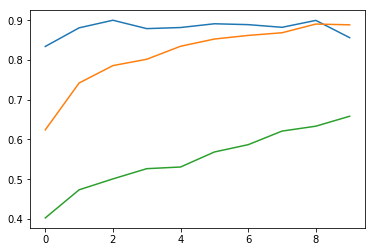

In [62]:
for val_acc in val_acc_hist:
    plt.plot(val_acc)

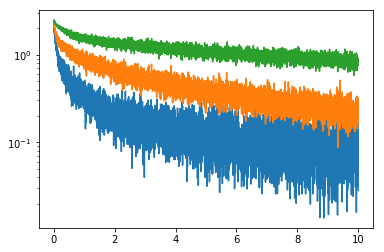

In [63]:
for loss in loss_hist:
    plt.semilogy(epoch,loss)